In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score,mean_squared_error,make_scorer
import math
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [51]:
""" Whats in this file
1. Pick features to model based on 
a. variance, 
b. correlation and 
c. Sequential Feature Selector
d. decision tree based importances"""

' Whats in this file\n1. Pick features to model based on \na. variance, \nb. correlation and \nc. Sequential Feature Selector'

In [52]:
turbine_data=pd.read_excel('cleaned_turbine_data.xlsx')
turbine_data.set_index('TimeStamp',inplace=True)
cols=turbine_data.columns

In [53]:
#The distribution curves dont follow a bell curve. So we can standardize it to represent normal distribution

In [54]:
X=turbine_data.loc[:,'Exhaust temp':'Comp discharge temp']
y=turbine_data.loc[:,'Generated watts']

In [60]:
def accuracyScore():
    classifier_pipeline = make_pipeline(StandardScaler(), LinearRegression())
    y_pred = cross_val_predict(classifier_pipeline,X,y, cv=10)
    print("R_squared: " + str(round(r2_score(y,y_pred),4)))
    print("RMSE: " + str(round(math.sqrt(mean_squared_error(y,y_pred)),4)))

In [61]:
accuracyScore()

R_squared: 0.9948
RMSE: 2.6563


In [57]:
# Filter features based on variance. Feature with low variance dont have much to attribute

In [63]:
var_matrix=turbine_data.var()
var_matrix

Generated watts              1361.088956
Exhaust temp               220438.782265
Comp Inlet Temp                64.716092
Comp IGV angle                600.897404
Comp discharge pressure      5732.908934
Comp discharge temp         73110.524698
dtype: float64

In [ ]:
"""even from previous correlation heat map; Comp Inlet temp had low correlation with other features. 
Checking for improvement in score by removing it. """

In [64]:
low_variance_features=var_matrix[var_matrix<100].index.to_list()

In [65]:
X=X.drop(columns=low_variance_features)

In [66]:
accuracyScore()

R_squared: 0.9949
RMSE: 2.6462


In [68]:
corr_matrix=turbine_data.drop(columns=low_variance_features).corr(method='kendall')

In [73]:
(corr_matrix['Generated watts'].drop('Generated watts')).sort_values(ascending=False)

Comp discharge pressure    0.639376
Comp IGV angle             0.592611
Exhaust temp               0.502490
Comp discharge temp        0.444930
Name: Generated watts, dtype: float64

In [74]:
# as the correlation values are really close, I dont want to delete anything now. 
# I am going to further check using Sequential feature selection technique.

In [82]:
r2=make_scorer(r2_score)
k=X.shape[1]
classifier_pipeline = make_pipeline(StandardScaler(), LinearRegression())
sfs=SFS(classifier_pipeline,k_features=k,forward=True,scoring=r2,cv=10)

In [83]:
sfs=sfs.fit(X,y)
sfs.subsets_

{1: {'feature_idx': (1,),
  'cv_scores': array([0.47630682, 0.99212942, 0.99468378, 0.99083252, 0.98032153,
         0.98929223, 0.99012002, 0.97887894, 0.96546557, 0.93622697]),
  'avg_score': 0.9294257806874386,
  'feature_names': ('Comp IGV angle',)},
 2: {'feature_idx': (1, 2),
  'cv_scores': array([0.46947509, 0.99110256, 0.98990628, 0.99251041, 0.98534041,
         0.99335916, 0.99099119, 0.99266405, 0.98464518, 0.97445969]),
  'avg_score': 0.9364454012699583,
  'feature_names': ('Comp IGV angle', 'Comp discharge pressure')},
 3: {'feature_idx': (1, 2, 3),
  'cv_scores': array([0.70449497, 0.99192326, 0.99202182, 0.98883844, 0.98315619,
         0.9942442 , 0.99137223, 0.99348833, 0.98687734, 0.98059351]),
  'avg_score': 0.9607010297664964,
  'feature_names': ('Comp IGV angle',
   'Comp discharge pressure',
   'Comp discharge temp')},
 4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([0.84333506, 0.99199668, 0.99285248, 0.99061932, 0.98256841,
         0.99472933, 0.98896523

In [85]:
# results from forward selection -> all 4 features together yield better result.
# I am going to check with sequential backward selection

In [86]:
sfs_bward=SFS(classifier_pipeline,k_features=1,forward=False,scoring=r2,cv=10)
sfs_bward=sfs_bward.fit(X,y)
sfs_bward.subsets_

{4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([0.84333506, 0.99199668, 0.99285248, 0.99061932, 0.98256841,
         0.99472933, 0.98896523, 0.99442425, 0.98879432, 0.98498573]),
  'avg_score': 0.9753270804977763,
  'feature_names': ('Exhaust temp',
   'Comp IGV angle',
   'Comp discharge pressure',
   'Comp discharge temp')},
 3: {'feature_idx': (0, 1, 3),
  'cv_scores': array([0.79150949, 0.99020715, 0.99233567, 0.99416606, 0.97978567,
         0.99386309, 0.98479348, 0.99223547, 0.98472862, 0.97711438]),
  'avg_score': 0.9680739060341109,
  'feature_names': ('Exhaust temp', 'Comp IGV angle', 'Comp discharge temp')},
 2: {'feature_idx': (0, 1),
  'cv_scores': array([0.44041024, 0.98938014, 0.98894659, 0.9882483 , 0.98265669,
         0.99228888, 0.9869617 , 0.99012945, 0.98017531, 0.96505039]),
  'avg_score': 0.9304247697500239,
  'feature_names': ('Exhaust temp', 'Comp IGV angle')},
 1: {'feature_idx': (1,),
  'cv_scores': array([0.47630682, 0.99212942, 0.99468378, 0.9908325

In [132]:
# For final step; ordering feature importances using decision tree
from sklearn.tree import DecisionTreeRegressor 
regressor=DecisionTreeRegressor()
regressor.fit(X,y)   

DecisionTreeRegressor()

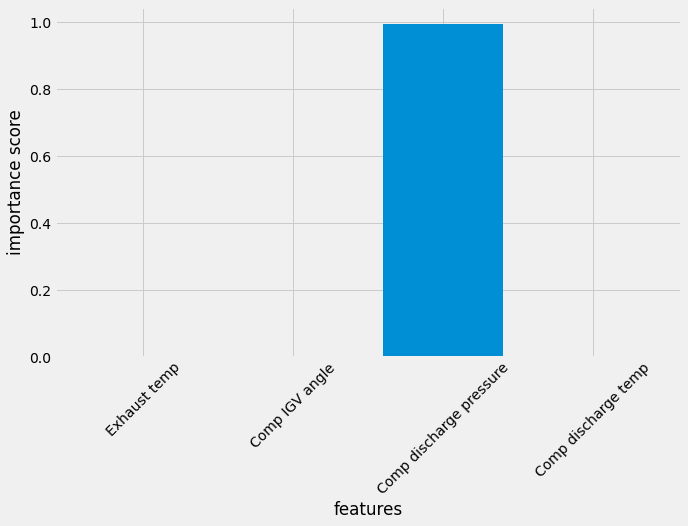

In [133]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
plt.bar(list(X.columns),list(regressor.feature_importances_))
plt.xlabel('features')
plt.ylabel('importance score')
plt.xticks(rotation=45)
plt.show()